In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch
from sklearn import metrics

def plot_images(images):
  n_images = len(images)
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure()
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap = 'bone')
    ax.axis('off')
  fig.show()
"""
Defaultowe wartości:
 - 1 warstwa ukryta - 100 neuronów
 - 2 warstwa ukryta - 50 neuronów
 - funkcje aktywacji - ReLU
 
 Jak zmiana ma wpływ na wyniki?
 Czym jest nn.Linear?
"""

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, inp, out, out1):
    super().__init__()
    self.input_fc = nn.Linear(input_dim, inp)
    self.hidden_fc = nn.Linear(inp, out)
    self.hidden_fc1 = nn.Linear(out, out1)
    self.output_fc = nn.Linear(out1, output_dim)

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    h_1 = F.relu(self.input_fc(x))
    h_1 = F.relu(self.hidden_fc(h_1))
    h_2 = F.relu(self.hidden_fc1(h_1))
    y_pred = self.output_fc(h_2)
    return y_pred, h_2

"""
Jak działa obliczanie dokładności modelu?
"""
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

"""
Opisać algorytm uczący - co można poprawić i jak?
"""
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Niektóre warstwy inaczej zachowują się podczas treningu a inaczej podczas ewaluacji.
  # Dobrą praktyką jest zaznaczenie, że sieć jest w "trybie uczenia"
  model.train()
  for (x, y) in iterator:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


"""
Na czym polega ewaluacja modelu?
"""
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs


def get_predictions(model, iterator, device):
  model.eval()
  images = []
  labels = []
  probs = []
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim = -1)

      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

"""
 Czym jest "Confusion matrix"? Opisać dla wyników modelu.
"""
def plot_confusion_matrix(labels, pred_labels):
  fig = plt.figure(figsize = (10, 10))
  ax = fig.add_subplot(1, 1, 1)
  cm = metrics.confusion_matrix(labels, pred_labels)
  cm = metrics.ConfusionMatrixDisplay(cm, range(10))
  cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
  fig.show()


def plot_most_incorrect(incorrect, n_images):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (20, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    true_prob = probs[true_label]
    incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
    ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
    ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                 f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
    ax.axis('off')
  fig.subplots_adjust(hspace= 0.5)
  fig.show()

"""
 Zobrazowanie wag pierwszej warstwy modelu.
 Może jakiś neuron nauczył się rozpoznawać konkretny wzór?
 Podać przykład.
"""
def plot_weights(weights, n_weights):
  rows = int(np.sqrt(n_weights))
  cols = int(np.sqrt(n_weights))
  fig = plt.figure(figsize = (20, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap = 'bone')
    ax.axis('off')
  fig.show()

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# torchvision - zbiory danych dotyczące computer vision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np

import copy
import random
import time

"""
Zadania:
1.Eksperymentalnie:
 - wybrać liczbę neuronów oraz warstw sieci
 - wybrać liczbę epok uczenia
 - znaleźć miejsca na przyspieszenie oraz propozycje zmiany (mając na uwadze, że pętle 'for' są bardzo wolne)
 - jak długo trwa uczenie dla różnych konfiguracji liczby neuronów oraz warstw?

2. Wypisać funkcje biblioteki PyTorch użyte w programie wraz z krótki opis działania
 oraz dlaczego zostały zastosowane

3. Odpowiedzieć na pytania zadane w komentarzach.
"""
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

"""
 PRZYGOTOWANIE DANYCH
"""

# Ładowanie zbioru danych MNIST do folderu 'data'
ROOT = 'data'

train_data = datasets.MNIST(root = ROOT,
                            train = True,
                            download = True)
# Normalizacja danych
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624
Number of training examples: 60000
Number of testing examples: 10000


/home/rhag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


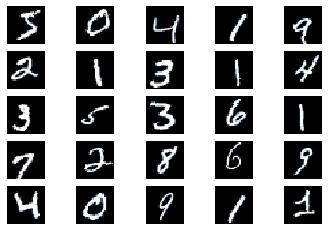

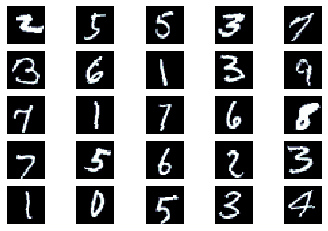

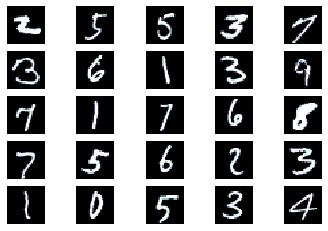

In [33]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

# Transformacje - najpierw wykonujemy transformacje na obrazie PIL (Python Imaging Library, Pillow)
# Normalizacje wykonujemy na tensorze
# https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image
# https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-torch-tensor

# Co dokładnie wykonują transformacje?
train_transforms = transforms.Compose([
  transforms.RandomRotation(5, fill=(0,)),
  transforms.RandomCrop(28, padding = 2),
  transforms.ToTensor(),
  transforms.Normalize(mean = [mean], std = [std])
])

test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean = [mean], std = [std])
])

train_data = datasets.MNIST(root = ROOT,
                            train = True,
                            download = True,
                            transform = train_transforms)

test_data = datasets.MNIST(root = ROOT,
                           train = False,
                           download = True,
                           transform = test_transforms)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

# Prezentacja kliku zdjęć ze zbioru danych
N_IMAGES = 25

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
plot_images(images)

# Zbiór danych MNIST nie zawiera zbioru walidacyjnego.
# Zabieramy 10% zbioru treningowego na zbiór walidacyjny

VALIDATION_SET_RATIO = 0.9
n_train_examples = int(len(train_data) * VALIDATION_SET_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# Zbiór walidacyjny zawiera transformacje zbioru treningowego
images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images)

# Zamiana transformacji
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

# Porównanie obrazków po transformacji (bardziej zcentrowane)
images = [image for image, label in [valid_data[i] for i in range(N_IMAGES)]]
plot_images(images)

# Definicja DataLoader'ów (czym są DataLoader'y)?
# Co oznacza i do czego jest używany parametr shuffle = True w zbiorze treningowym?
BATCH_SIZE = 64
train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)


In [41]:
"""
 DEFINICJA MODELU
"""

# Obrazek jest jednokolorowy o wymiarach 28 x 28
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM,500,100,50)

# Wyliczenie liczby parametrów modelu
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')
"""
 UCZENIE
"""

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
# Umieszczenie modelu oraz danych na GPU (jeśli jest dostępne)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 10  # Ustawione na 1, gdyż uczenie może zająć chwilę czasu...

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
  start_time = time.time()
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  # ewaluacja modelu na zbiorze walidacyjnym
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'nn_model.pt')

  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Jaki model został zapisany w pliku 'nn_model'?
model.load_state_dict(torch.load('nn_model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

The model has 448,160 trainable parameters
Epoch:  1 | Epoch Time: 0m 28s
	Train Loss: 0.395 | Train Acc: 87.37%
	 Val. Loss: 0.161 |  Val. Acc: 94.99%
Epoch:  2 | Epoch Time: 0m 32s
	Train Loss: 0.162 | Train Acc: 94.99%
	 Val. Loss: 0.104 |  Val. Acc: 96.83%
Epoch:  3 | Epoch Time: 0m 30s
	Train Loss: 0.131 | Train Acc: 95.86%
	 Val. Loss: 0.098 |  Val. Acc: 96.83%
Epoch:  4 | Epoch Time: 0m 29s
	Train Loss: 0.113 | Train Acc: 96.44%
	 Val. Loss: 0.095 |  Val. Acc: 97.03%
Epoch:  5 | Epoch Time: 0m 28s
	Train Loss: 0.101 | Train Acc: 96.87%
	 Val. Loss: 0.082 |  Val. Acc: 97.49%
Epoch:  6 | Epoch Time: 0m 32s
	Train Loss: 0.093 | Train Acc: 97.22%
	 Val. Loss: 0.095 |  Val. Acc: 97.26%
Epoch:  7 | Epoch Time: 0m 33s
	Train Loss: 0.085 | Train Acc: 97.32%
	 Val. Loss: 0.077 |  Val. Acc: 97.65%
Epoch:  8 | Epoch Time: 0m 33s
	Train Loss: 0.082 | Train Acc: 97.43%
	 Val. Loss: 0.075 |  Val. Acc: 97.63%
Epoch:  9 | Epoch Time: 0m 33s
	Train Loss: 0.081 | Train Acc: 97.52%
	 Val. Loss: 0.

/home/rhag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/rhag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:148: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/rhag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


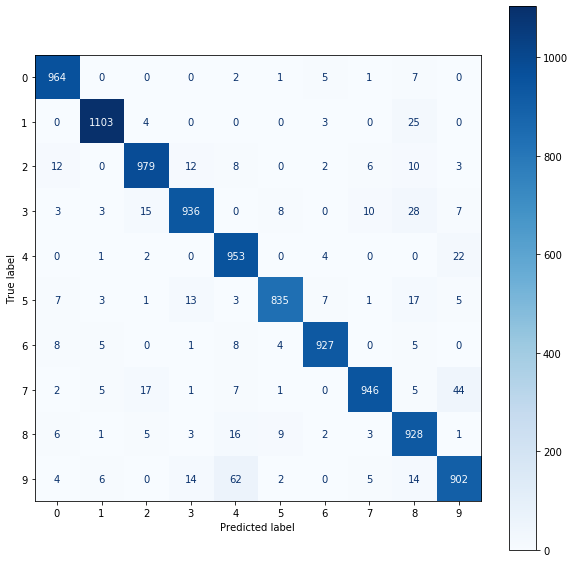

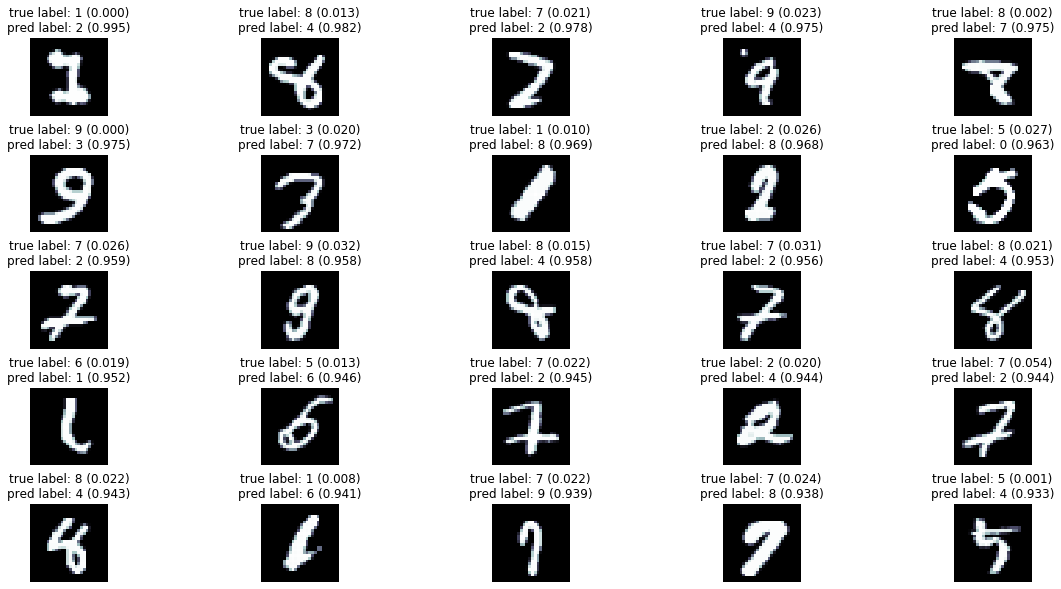

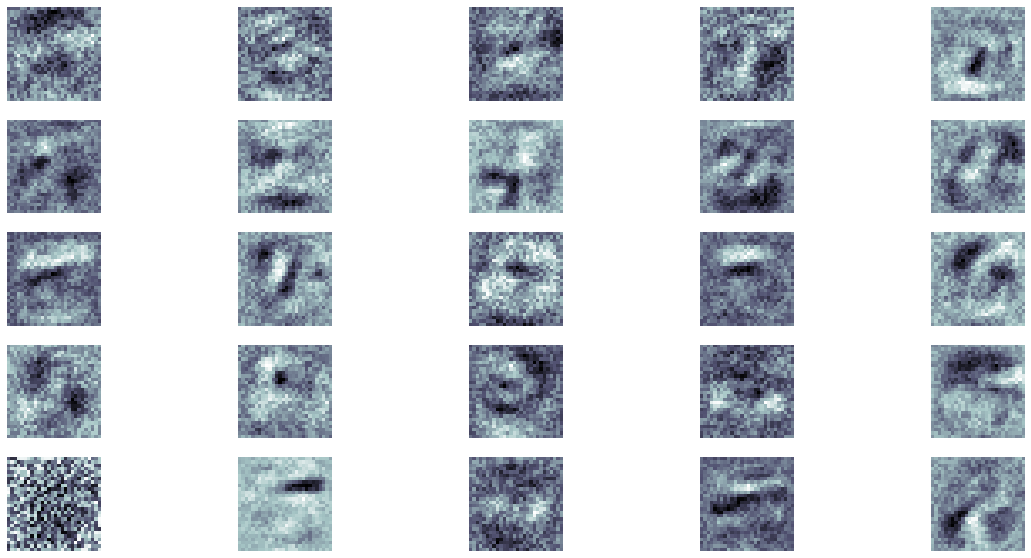

In [22]:
"""
 ANALIZA MODELU
"""

images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)

plot_confusion_matrix(labels, pred_labels)
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)
plot_most_incorrect(incorrect_examples, N_IMAGES)
# Dlaczego te obrazki mogły zostać nieprawidłowo sklasyfikowane?

N_WEIGHTS = 25
weights = model.input_fc.weight.data
plot_weights(weights, N_WEIGHTS)